In [29]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random
import tensorflow as tf
from tensorflow import keras
import keras.layers as tfl
import seaborn as sn
import dataset

In [30]:
# interfacce function to get splited dataset
# resize all audio to (19, 1841) matrix
# 1841 is the max size of Japanese audio
dataset_collection = dataset.getMFCCDatasetRAVDESS(train_size = 0.6, valid_size = 0.2, test_size = 0.2, cut = False, emotion_number = 3, max_len = 1841)

X_train = dataset_collection['X_train']
Y_train = dataset_collection['Y_train']
X_valid = dataset_collection['X_valid']
Y_valid = dataset_collection['Y_valid']
X_test = dataset_collection['X_test']
Y_test = dataset_collection['Y_test']

X_train_norm = dataset_collection['X_train_norm']
X_valid_norm = dataset_collection['X_valid_norm']
X_test_norm = dataset_collection['X_test_norm']

In [31]:
print(dataset_collection)

{'X_train': array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],


In [32]:
print(X_train.shape)

(287, 1841, 19)


In [33]:
# convert array to tensor
X_train_norm = tf.convert_to_tensor(X_train_norm)
X_valid_norm = tf.convert_to_tensor(X_valid_norm)
X_test_norm = tf.convert_to_tensor(X_test_norm)
Y_train = tf.convert_to_tensor(Y_train)
Y_valid = tf.convert_to_tensor(Y_valid)
Y_test = tf.convert_to_tensor(Y_test)

X_train = tf.convert_to_tensor(X_train)
X_valid = tf.convert_to_tensor(X_valid)
X_test = tf.convert_to_tensor(X_test)

Build model for English dataset

In [34]:
def convolutional_model(input_shape):
        """
        Implements the forward propagation for the model:
        CONV2D -> RELU -> MAXPOOL -> CONV2D -> Softmax -> MAXPOOL -> FLATTEN -> DENSE
        
        Arguments:
        input_mfcc -- input dataset, of shape (input_shape)

        Returns:
        model -- TF Keras model (object containing the information for the entire training process) 
        """

        input_mfcc = tf.keras.Input(shape=input_shape)
        ## CONV1D: 4 filters 8, stride of 1, padding 'SAME'
        Z1 = tfl.Conv1D(filters = 2, kernel_size = 8, strides = 2, padding='same', kernel_initializer = 'he_normal', kernel_regularizer = 'L1')(input_mfcc)
        ## RELU
        A1 = tfl.ReLU()(Z1)
        ## MAXPOOL: window 8, stride 4, padding 'SAME'
        P1 = tfl.MaxPool1D(pool_size = 8, strides = 4, padding='same')(A1)
        
        # D1 = tfl.Dropout(0.2)(P1)

        ## CONV1D: 2 filters 4, stride 1, padding 'SAME'
        Z2 = tfl.Conv1D(filters = 2, kernel_size = 4, strides = 2, padding='same', kernel_initializer = 'he_normal', kernel_regularizer = 'L1')(P1)
        ## RELU
        A2 = tfl.ReLU()(Z2)
        ## MAXPOOL: window 4, stride 2, padding 'SAME'
        P2 = tfl.MaxPool1D(pool_size = 4, strides = 2, padding='same')(A2)

        # D2 = tfl.Dropout(0.2)(P2)

        # ## CONV1D: 2 filters 4, stride 1, padding 'SAME'
        # Z3 = tfl.Conv1D(filters = 2, kernel_size = 4, strides = 2, padding='same', kernel_initializer = 'he_normal', kernel_regularizer = 'L1')(D2)
        # ## RELU
        # A3 = tfl.ReLU()(Z3)
        # ## MAXPOOL: window 4, stride 2, padding 'SAME'
        # P3 = tfl.MaxPool1D(pool_size = 4, strides = 2, padding='same')(A3)

        # D3 = tfl.Dropout(0.2)(P3)

        ## FLATTEN
        F = tfl.Flatten()(P2)
        # D3 = tfl.Dropout(0.2)(F)
        ## Dense layer
        ## 6 neurons in output layer. Hint: one of the arguments should be "activation='softmax'" 
        # Den1 = tfl.Dense(64, activation='ReLU', kernel_regularizer = 'L1')(F)
        outputs = tfl.Dense(3, activation='softmax')(F)
        model = tf.keras.Model(inputs=input_mfcc, outputs=outputs)
        return model


In [35]:
# conv_model = CNN_RAVDESS.CNN.convolutional_model((1841, 19))
conv_model = convolutional_model((1841, 19))
conv_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
conv_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1841, 19)]        0         
                                                                 
 conv1d_2 (Conv1D)           (None, 921, 2)            306       
                                                                 
 re_lu_2 (ReLU)              (None, 921, 2)            0         
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 231, 2)           0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 116, 2)            18        
                                                                 
 re_lu_3 (ReLU)              (None, 116, 2)            0         
                                                           

Train model on English dataset

In [36]:
print(X_train_norm.shape)

(287, 1841, 19)


In [37]:
history = conv_model.fit(X_train_norm, Y_train, epochs=100, validation_data=(X_valid_norm, Y_valid))

Epoch 1/100
9/9 [==============================] - 2s 81ms/step - loss: 1.5966 - accuracy: 0.3171 - val_loss: 1.5344 - val_accuracy: 0.2421
Epoch 2/100
9/9 [==============================] - 0s 32ms/step - loss: 1.4757 - accuracy: 0.3589 - val_loss: 1.4658 - val_accuracy: 0.2842
Epoch 3/100
9/9 [==============================] - 0s 35ms/step - loss: 1.3924 - accuracy: 0.4216 - val_loss: 1.4265 - val_accuracy: 0.3789
Epoch 4/100
9/9 [==============================] - 0s 35ms/step - loss: 1.3486 - accuracy: 0.4564 - val_loss: 1.3923 - val_accuracy: 0.4000
Epoch 5/100
9/9 [==============================] - 0s 34ms/step - loss: 1.3173 - accuracy: 0.4774 - val_loss: 1.3705 - val_accuracy: 0.4211
Epoch 6/100
9/9 [==============================] - 0s 32ms/step - loss: 1.2909 - accuracy: 0.4739 - val_loss: 1.3506 - val_accuracy: 0.4737
Epoch 7/100
9/9 [==============================] - 0s 33ms/step - loss: 1.2652 - accuracy: 0.5017 - val_loss: 1.3323 - val_accuracy: 0.4421
Epoch 8/100
9/9 [===

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

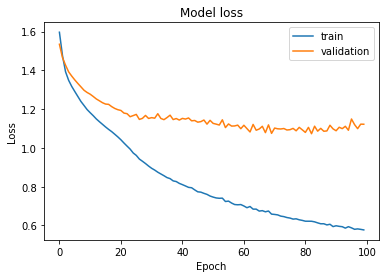

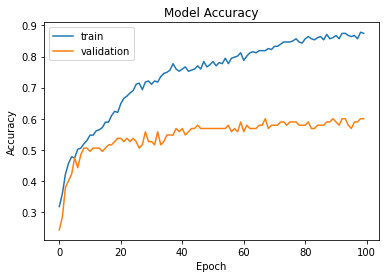

In [38]:
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(6,4)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(6,4)).set(xlabel='Epoch',ylabel='Accuracy')

4/4 [==============================] - 0s 8ms/step


[Text(0.5, 15.0, 'prediction'), Text(33.0, 0.5, 'actual')]

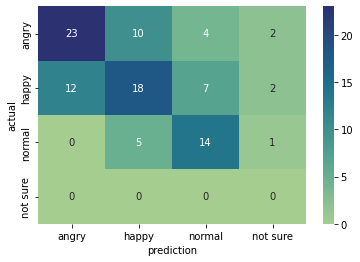

In [39]:
Y_pred = conv_model.predict(X_test_norm)
Y_test_numpy = Y_test.numpy()
emotion_pred = []
emotion_test = []
for i in range(len(Y_pred)):
    if (Y_pred[i][0] > 0.5):
        emotion_pred.append(0) # angry
    elif (Y_pred[i][1] > 0.5):
        emotion_pred.append(1) # happy
    elif (Y_pred[i][2] > 0.5):
        emotion_pred.append(2) # normal
    else:
        emotion_pred.append(3) # not decided

    if (Y_test_numpy[i][0] > 0.5):
        emotion_test.append(0)
    elif (Y_test_numpy[i][1] > 0.5):
        emotion_test.append(1)
    elif (Y_test_numpy[i][2] > 0.5):
        emotion_test.append(2)

emotion_test = tf.convert_to_tensor(emotion_test)
emotion_pred = tf.convert_to_tensor(emotion_pred)

confusion = tf.math.confusion_matrix(emotion_test, emotion_pred, num_classes = 4)

df=pd.DataFrame(confusion.numpy(),index=['angry', 'happy', 'normal', 'not sure'],columns=['angry', 'happy', 'normal', 'not sure'])
confusiton_map = sn.heatmap(df,annot=True, cmap='crest')
confusiton_map.set(xlabel="prediction", ylabel="actual")

Build transfer model

apply it on Japanese dataset

In [40]:
dataset_collection = dataset.getMFCCDataset(train_size = 0.6, valid_size = 0.2, test_size = 0.2, cut = False, max_len = 1841)

jap_X_train = dataset_collection['X_train']
jap_Y_train = dataset_collection['Y_train']
jap_X_valid = dataset_collection['X_valid']
jap_Y_valid = dataset_collection['Y_valid']
jap_X_test = dataset_collection['X_test']
jap_Y_test = dataset_collection['Y_test']

jap_X_train_norm = dataset_collection['X_train_norm']
jap_X_valid_norm = dataset_collection['X_valid_norm']
jap_X_test_norm = dataset_collection['X_test_norm']

# convert array to tensor
jap_X_train_norm = tf.convert_to_tensor(jap_X_train_norm)
jap_X_valid_norm = tf.convert_to_tensor(jap_X_valid_norm)
jap_X_test_norm = tf.convert_to_tensor(jap_X_test_norm)
jap_Y_train = tf.convert_to_tensor(jap_Y_train)
jap_Y_valid = tf.convert_to_tensor(jap_Y_valid)
jap_Y_test = tf.convert_to_tensor(jap_Y_test)

jap_X_train = tf.convert_to_tensor(jap_X_train)
jap_X_valid = tf.convert_to_tensor(jap_X_valid)
jap_X_test = tf.convert_to_tensor(jap_X_test)

In [41]:
jap_X_test.shape

TensorShape([180, 1841, 19])

In [42]:
def transfer_model(japanese_input_size):
    conv_model.trainable = False
    inputs = tf.keras.Input(japanese_input_size)
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = conv_model(inputs, training=False) 
    
    # reshape x to fit requirement of global average pooling 1d
    x = tf.keras.layers.Reshape((1,3))(x)
    # # add the new Binary classification layers
    # # use global avg pooling to summarize the info in each channel
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    # # include dropout with probability of 0.2 to avoid overfitting
    # x = tf.keras.layers.Dropout(0.2)(x)
    # # use a prediction layer with three neuron (as three emotions in Japanese dataset)
    outputs = tf.keras.layers.Dense(3)(x)
    
    
    model = tf.keras.Model(inputs, outputs)

    return model

In [43]:
base_learning_rate = 0.01
jap_transfer_model = transfer_model((1841, 19))
jap_transfer_model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
jap_transfer_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1841, 19)]        0         
                                                                 
 model_3 (Functional)        (None, 3)                 675       
                                                                 
 reshape_2 (Reshape)         (None, 1, 3)              0         
                                                                 
 global_average_pooling1d_2   (None, 3)                0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_4 (Dense)             (None, 3)                 12        
                                                                 
Total params: 687
Trainable params: 12
Non-trainable params: 675
____________________________________________________________

In [44]:
jap_history = jap_transfer_model.fit(jap_X_train_norm, jap_Y_train, epochs=100, validation_data=(jap_X_valid_norm, jap_Y_valid))

Epoch 1/100
17/17 [==============================] - 2s 41ms/step - loss: 6.0189 - accuracy: 0.3685 - val_loss: 5.1369 - val_accuracy: 0.3667
Epoch 2/100
17/17 [==============================] - 0s 21ms/step - loss: 5.2537 - accuracy: 0.3685 - val_loss: 4.9381 - val_accuracy: 0.3167
Epoch 3/100
17/17 [==============================] - 0s 22ms/step - loss: 5.2719 - accuracy: 0.3315 - val_loss: 5.4626 - val_accuracy: 0.3222
Epoch 4/100
17/17 [==============================] - 0s 21ms/step - loss: 5.4854 - accuracy: 0.3833 - val_loss: 5.6528 - val_accuracy: 0.4222
Epoch 5/100
17/17 [==============================] - 0s 20ms/step - loss: 5.3811 - accuracy: 0.4037 - val_loss: 5.3837 - val_accuracy: 0.4278
Epoch 6/100
17/17 [==============================] - 0s 19ms/step - loss: 5.1747 - accuracy: 0.4019 - val_loss: 5.3826 - val_accuracy: 0.4222
Epoch 7/100
17/17 [==============================] - 0s 20ms/step - loss: 5.2003 - accuracy: 0.3981 - val_loss: 5.3773 - val_accuracy: 0.4222
Epoch 

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

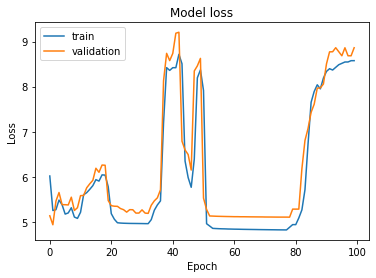

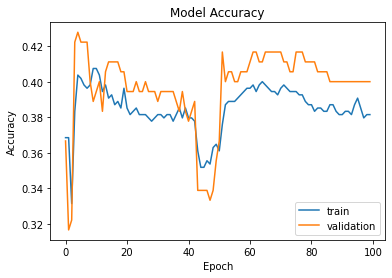

In [45]:
df_loss_acc = pd.DataFrame(jap_history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(6,4)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(6,4)).set(xlabel='Epoch',ylabel='Accuracy')

Fine tune

In [46]:
# the 2nd layer is CNN layer in conv_model
base_conv_model = jap_transfer_model.layers[1]
base_conv_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_conv_model.layers))

# Fine-tune from this layer onwards
# total layer number in conv_model is 9
fine_tune_at = 6

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_conv_model.layers[:fine_tune_at]:
    layer.trainable = False

jap_transfer_model.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.1 * base_learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
jap_transfer_model.summary()

Number of layers in the base model:  9
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1841, 19)]        0         
                                                                 
 model_3 (Functional)        (None, 3)                 675       
                                                                 
 reshape_2 (Reshape)         (None, 1, 3)              0         
                                                                 
 global_average_pooling1d_2   (None, 3)                0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_4 (Dense)             (None, 3)                 12        
                                                                 
Total params: 687
Trainable params: 363
Non-trainable params: 324
____________________

In [47]:
jap_transfer_history = conv_model.fit(jap_X_train_norm, jap_Y_train, epochs=50, validation_data=(jap_X_valid_norm, jap_Y_valid))

Epoch 1/50
17/17 [==============================] - 1s 40ms/step - loss: 2.6988 - accuracy: 0.3963 - val_loss: 1.7427 - val_accuracy: 0.4222
Epoch 2/50
17/17 [==============================] - 1s 37ms/step - loss: 1.4400 - accuracy: 0.5093 - val_loss: 1.3796 - val_accuracy: 0.4944
Epoch 3/50
17/17 [==============================] - 1s 39ms/step - loss: 1.1266 - accuracy: 0.6093 - val_loss: 1.1222 - val_accuracy: 0.6167
Epoch 4/50
17/17 [==============================] - 1s 36ms/step - loss: 1.0060 - accuracy: 0.6667 - val_loss: 1.0052 - val_accuracy: 0.6889
Epoch 5/50
17/17 [==============================] - 1s 35ms/step - loss: 0.9278 - accuracy: 0.7093 - val_loss: 0.9419 - val_accuracy: 0.7056
Epoch 6/50
17/17 [==============================] - 1s 41ms/step - loss: 0.8633 - accuracy: 0.7352 - val_loss: 0.8814 - val_accuracy: 0.7278
Epoch 7/50
17/17 [==============================] - 1s 47ms/step - loss: 0.8059 - accuracy: 0.7611 - val_loss: 0.8255 - val_accuracy: 0.7611
Epoch 8/50
17

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

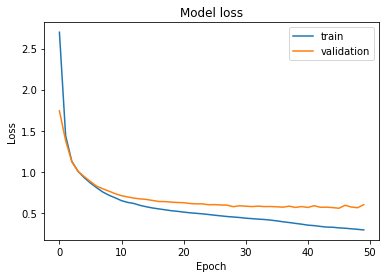

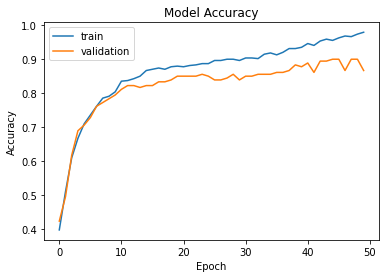

In [48]:
df_loss_acc = pd.DataFrame(jap_transfer_history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(6,4)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(6,4)).set(xlabel='Epoch',ylabel='Accuracy')

6/6 [==============================] - 0s 9ms/step


[Text(0.5, 15.0, 'prediction'), Text(33.0, 0.5, 'actual')]

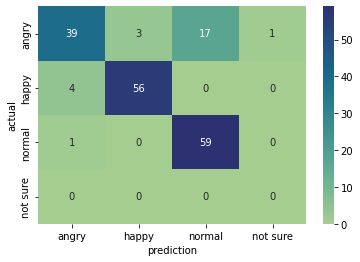

In [49]:
jap_Y_pred = conv_model.predict(jap_X_test_norm)
jap_Y_test_numpy = jap_Y_test.numpy()
jap_emotion_pred = []
jap_emotion_test = []
for i in range(len(jap_Y_pred)):
    if (jap_Y_pred[i][0] > 0.5):
        jap_emotion_pred.append(0) # angry
    elif (jap_Y_pred[i][1] > 0.5):
        jap_emotion_pred.append(1) # happy
    elif (jap_Y_pred[i][2] > 0.5):
        jap_emotion_pred.append(2) # normal
    else:
        jap_emotion_pred.append(3) # not decided

    if (jap_Y_test_numpy[i][0] > 0.5):
        jap_emotion_test.append(0)
    elif (jap_Y_test_numpy[i][1] > 0.5):
        jap_emotion_test.append(1)
    elif (jap_Y_test_numpy[i][2] > 0.5):
        jap_emotion_test.append(2)

jap_emotion_test = tf.convert_to_tensor(jap_emotion_test)
jap_emotion_pred = tf.convert_to_tensor(jap_emotion_pred)

jap_confusion = tf.math.confusion_matrix(jap_emotion_test, jap_emotion_pred, num_classes = 4)

jap_df=pd.DataFrame(jap_confusion.numpy(),index=['angry', 'happy', 'normal', 'not sure'],columns=['angry', 'happy', 'normal', 'not sure'])
confusiton_map = sn.heatmap(jap_df,annot=True, cmap='crest')
confusiton_map.set(xlabel="prediction", ylabel="actual")